# Deep Learning入門

## テストデータ

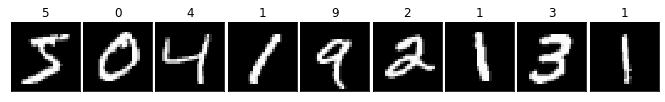

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot, to_categorical

%matplotlib inline

(x_train, y_train), (x_test, y_test) = mnist.load_data()

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

## 前処理

In [2]:
# 入力画像を行列(28x28)からベクトル(長さ784)に変換
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 名義尺度の値をone-hot表現へ変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## モデル作成

In [3]:
model = Sequential()

# 最初のlayerはinput_shapeを指定して、入力するデータの次元を与える必要がある
# Dense: 一般的な全結合層を表すレイヤー
# 初期化: Heの初期化法は活性化関数がReLUであるときに適している
model.add(Dense(units=256, input_shape=(784,),
                kernel_initializer='he_uniform'))
# Activation: 活性化関数として relu を選択
model.add(Activation('relu'))

# 同時に指定も可能
model.add(Dense(256, activation='relu'))

# ドロップアウト: 近似的にアンサンブル法を実現するもの
# ドロップアウトは入力の一部をランダムに0にして出力するlayerの一種。
# 訓練データセットから部分訓練データセットを大量に作成し、
# 各モデルの予測結果を平均する手法をアンサンブルというが、
# とてつもない計算量を要する
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# 正規化: L2正則化では、全パラメータの2乗和を正則化項として損失関数に加えます。
# L2正則化では、パラメータを完全に0にすることは少ないものの、
# パラメータを滑らかにすることで予測精度のより良いモデルを構築する
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# 正規化: L1正則化では、全パラメータの絶対値の和を正則化項として損失関数に加える。
# L1正則化ではL2正則化よりもパラメータが0になりやすいという特徴（スパース性）がある
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01)))

# 正規化: L1正則化とL2正則化の組み合わせのElasticNet
model.add(Dense(100, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))

model.add(Dense(units=10))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    # optimizer='sgd',
    optimizer=Adam(),
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6

## モデル可視化

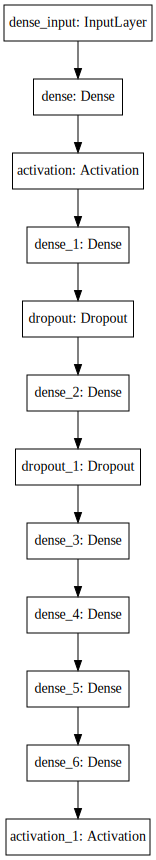

In [4]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

## モデル学習

In [5]:
history = model.fit(
    x_train, y_train,
    batch_size=1000, epochs=20, verbose=1,
    validation_data=(x_test, y_test),
    # 早期終了: 検証データの誤差が大きくなってきた（或いは評価関数値が下がってきた）ところで学習をストップさせる
    callbacks=[EarlyStopping(patience=0, verbose=1)]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 81us/sample - loss: 49.8375 - acc: 0.6043 - val_loss: 37.7433 - val_acc: 0.8843
Epoch 2/20
60000/60000 [==============================] - 3s 57us/sample - loss: 29.7695 - acc: 0.8707 - val_loss: 22.7350 - val_acc: 0.9282
Epoch 3/20
60000/60000 [==============================] - 3s 57us/sample - loss: 18.5227 - acc: 0.9136 - val_loss: 14.8086 - val_acc: 0.9447
Epoch 4/20
60000/60000 [==============================] - 3s 56us/sample - loss: 12.3858 - acc: 0.9323 - val_loss: 10.1507 - val_acc: 0.9518
Epoch 5/20
60000/60000 [==============================] - 3s 57us/sample - loss: 8.6274 - acc: 0.9446 - val_loss: 7.1917 - val_acc: 0.9582
Epoch 6/20
60000/60000 [==============================] - 3s 56us/sample - loss: 6.1989 - acc: 0.9516 - val_loss: 5.2364 - val_acc: 0.9618
Epoch 7/20
60000/60000 [==============================] - 3s 56us/sample - loss: 4.5541 - acc: 0.9563 - val_

## モデル評価

Test loss: 0.3904366277217865
Test accuracy: 0.9748


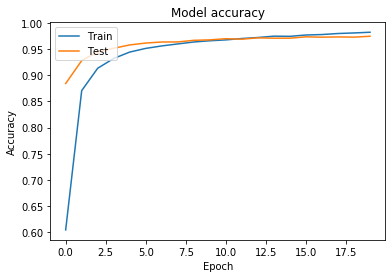

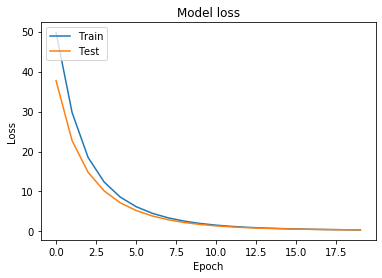

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 活性化関数

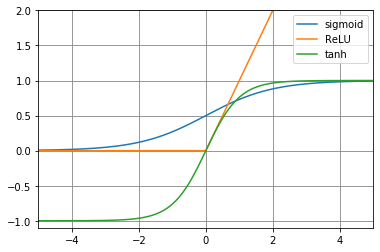

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


fig = plt.figure()
x = np.linspace(-10, 10, 1000)

ax = fig.add_subplot(111)
ax.plot(x, sigmoid(x), label='sigmoid')
ax.plot(x, relu(x), label='ReLU')
ax.plot(x, tanh(x), label='tanh')

plt.legend()
plt.xlim(-5, 5)
plt.ylim(-1.1, 2)
plt.grid(which='major', color='gray', linestyle='-')
plt.show()

## 活性化関数の微分

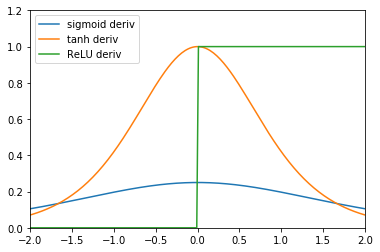

In [8]:
def deriv_sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))**2


def deriv_tanh(x):
    return 1 - np.tanh(x)**2


def deriv_relu(x):
    return 1 * (x > 0)


fig = plt.figure()
x = np.linspace(-10, 10, 1000)

# sigmoid
ax = fig.add_subplot(111)
ax.plot(x, deriv_sigmoid(x), label='sigmoid deriv')

# tanh
ax.plot(x, deriv_tanh(x), label='tanh deriv')

# relu
ax.plot(x, deriv_relu(x), label='ReLU deriv')

plt.legend()
plt.xlim(-2, 2)
plt.ylim(0, 1.2)
plt.show()